In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import sklearn.metrics as metrics

In [2]:
# Load the dataset
df = pd.read_excel('energy.xlsx', names=['Relative Compactness', 'Surface Area', 'Wall Area',
                                         'Roof Area', 'Overall Height','Orientation',
                                         'Glazing Area', 'Glazing Area Distribution',
                                         'Heating Load'])
df

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48


# Feature Engineering

In [3]:
# correlation analysis
corrMatrix = df.corr()
corrMatrix.style.background_gradient(cmap='Blues')

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
Relative Compactness,1.000000,-0.991901,-0.203782,-0.868823,0.827747,0.000000,0.000000,0.000000,0.622272
Surface Area,-0.991901,1.000000,0.195502,0.880720,-0.858148,0.000000,0.000000,-0.000000,-0.658120
Wall Area,-0.203782,0.195502,1.000000,-0.292316,0.280976,0.000000,-0.000000,0.000000,0.455671
Roof Area,-0.868823,0.880720,-0.292316,1.000000,-0.972512,0.000000,-0.000000,-0.000000,-0.861828
Overall Height,0.827747,-0.858148,0.280976,-0.972512,1.000000,0.000000,0.000000,0.000000,0.889430
Orientation,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.002587
Glazing Area,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000,0.212964,0.269842
Glazing Area Distribution,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.212964,1.000000,0.087368
Heating Load,0.622272,-0.658120,0.455671,-0.861828,0.889430,-0.002587,0.269842,0.087368,1.000000


In [4]:
# separate label column
X = df.copy()
del(X['Heating Load'])
X = np.array(X)
Y = np.array(df['Heating Load'])

In [5]:
# Recursive Feature Elimination - feature selection
from sklearn.feature_selection import RFE
model = linear_model.LinearRegression()
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 3
Selected Features: [False  True  True  True False False False False]
Feature Ranking: [2 1 1 1 4 6 3 5]


# Validation strategy 

In [6]:
# train/test split using index number
# Split the data into training/testing sets
X_train = X[:-100]
X_test = X[-100:]

# Split the targets into training/testing sets
Y_train = Y[:-100]
Y_test = Y[-100:]

In [7]:
# train/test split with scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)
print(len(X_train))
print(len(X_test))

614
154


In [8]:
# set seed for any random process is important to reprodudce the results
np.random.seed(0)

In [9]:
# K-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=0, n_splits=5)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index],Y[test_index]
    ### Important: do the training and model evaluation inside the K-fold CV loop
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    rmse = metrics.mean_squared_error(Y_pred, Y_test)
    print(rmse)


10.097910145687448
9.603901902401628
8.819851870101612
7.805691051862854
7.379525589368797


In [10]:
# K-Fold cross validation with cross val score
from sklearn.model_selection import cross_val_score, KFold
model = linear_model.LinearRegression()
cv = KFold(shuffle=True, random_state=0, n_splits=5)
scores = cross_val_score(model, X, Y, cv = cv, scoring = 'neg_mean_squared_error')
print(scores)

[-10.09791015  -9.6039019   -8.81985187  -7.80569105  -7.37952559]


# Simple Linear Regression

In [11]:
# Use only one feature
X_one = np.array(df['Surface Area'])
X_one.shape

(768,)

In [12]:
# reshape to have a 2D array to avoid error
X_one = X_one.reshape(len(X_one),1)

In [13]:
# Repeat the train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_one, Y, test_size=0.2, random_state=0, shuffle=True)

In [14]:
# Train the model using the training sets
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [15]:
# Make predictions using the testing set
Y_pred = model.predict(X_test)

In [16]:
# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(Y_pred, Y_test))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(Y_pred, Y_test))

Coefficients: 
 [-0.07618897]
Mean squared error: 70.19
Coefficient of determination: -0.56


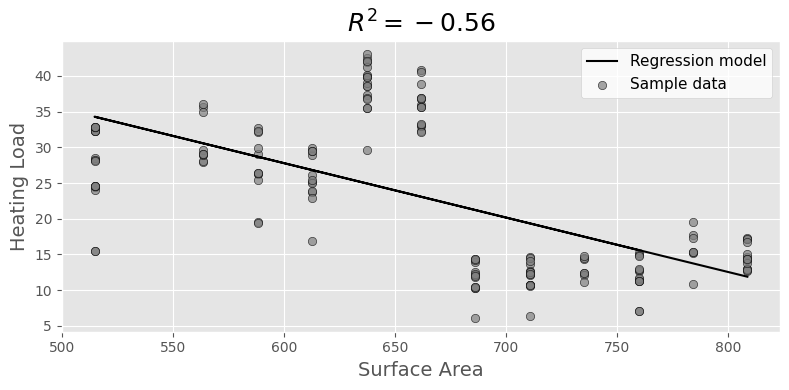

In [17]:
# visualisation
r2 = metrics.r2_score(Y_pred, Y_test)
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X_test, Y_pred, color='k', label='Regression model')
ax.scatter(X_test, Y_test, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Heating Load', fontsize=14)
ax.set_xlabel('Surface Area', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

fig.tight_layout()

# Multiple Linear Regression

In [18]:
# Repeat the train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

In [19]:
# Train the model using the training sets
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [20]:
# Make predictions using the testing set
Y_pred = model.predict(X_test)

In [21]:
# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(Y_pred, Y_test))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(Y_pred, Y_test))

Coefficients: 
 [-5.93338709e+01 -9.33419864e+11  9.33419864e+11  1.86683973e+12
  4.04596519e+00 -2.17393786e-02  1.98405322e+01  1.56769976e-01]
Mean squared error: 10.05
Coefficient of determination: 0.89


# Polinomial Regression

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', linear_model.LinearRegression())])
# fit to an order-2 polynomial data
model = model.fit(X_train,Y_train)

In [23]:
# Make predictions using the testing set
Y_pred = model.predict(X_test)

In [24]:
# The coefficients
print('Coefficients: \n', model.named_steps['linear'].coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(Y_pred, Y_test))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(Y_pred, Y_test))

Coefficients: 
 [-1.30650174e+08  1.17336714e+06  7.27308939e+05 -7.25847633e+05
 -1.22970594e+06  2.45939337e+05 -1.60232809e+00  1.04379113e+02
  3.87494223e+00 -1.68725046e+05 -2.74295845e+05  2.73957511e+05
  5.45527893e+05 -4.75047570e+04  1.22257291e+00 -3.98009993e+00
 -9.92735781e-01 -2.72042338e+08  2.64283261e+08  5.26194906e+08
 -2.51023839e+05  3.07413594e+05  5.78348642e+04  2.22778427e+05
  7.75907624e+06  3.34079187e+07  2.50956247e+05 -3.07413593e+05
 -5.78348719e+04 -2.22778428e+05  3.57795311e+07  4.70828739e+05
 -6.14827186e+05 -1.15670005e+05 -4.45556860e+05  6.36774924e+05
 -1.84321906e-02 -3.44627696e+00 -4.58390946e-02 -4.39005945e-02
  3.43861720e-01  7.56094486e-03 -1.93448410e+01 -1.88388431e+00
 -1.49171273e-01]
Mean squared error: 0.67
Coefficient of determination: 0.99
